In [1]:
import pandas as pd
from datetime import datetime, timedelta

In [2]:
def extract_pulse_data(csv_file_path):
    """
    Extraer datos de pulso según criterios específicos:
    1. Primera fila (pulse_bpm = 0.0)
    2. Primera fila donde pulse_bpm ≠ 0.0
    3. Cada 2 segundos a partir de ahí
    
    Args:
        csv_file_path: Ruta al archivo CSV
        
    Returns:
        DataFrame con las filas extraída y solo las columnas 'timestamp' y 'pulse_bpm'
    """
    print(f"Cargando archivo: {csv_file_path}")
    
    # Leer CSV saltando las líneas de metadatos (que empiezan con #)
    df = pd.read_csv(csv_file_path, comment='#')
    
    print(f"Datos cargados: {len(df)} filas")
    print(f"Rango temporal: {df['timestamp'].iloc[0]} a {df['timestamp'].iloc[-1]}")
    
    # Lista para almacenar índices de filas a extraer
    selected_indices = []
    
    # 1. PRIMERA FILA (siempre pulse_bpm = 0.0)
    selected_indices.append(0)
    
    # 2. PRIMERA FILA CON BPM VÁLIDO (≠ 0.0)
    first_valid_idx = None
    for idx, bpm in enumerate(df['pulse_bpm']):
        if bpm != 0.0:
            first_valid_idx = idx
            selected_indices.append(idx)
            print(f"✓ Primera medición válida en fila {idx}: {df['timestamp'].iloc[idx]} - BPM: {bpm:.1f}")
            break
    
    if first_valid_idx is None:
        print("⚠️ No se encontraron mediciones de BPM válidas")
        return df[['timestamp', 'pulse_bpm']].iloc[selected_indices]
    
    # 3. EXTRAER CADA 2 SEGUNDOS A PARTIR DE LA PRIMERA MEDICIÓN VÁLIDA
    
    # Convertir timestamps a datetime para cálculos temporales
    def parse_timestamp(ts_str):
        """Convertir timestamp HH:MM:SS.mmm a datetime"""
        time_part = datetime.strptime(ts_str, "%H:%M:%S.%f").time()
        # Usar fecha base (no importa cuál para diferencias)
        return datetime.combine(datetime(2025, 1, 1), time_part)
    
    # Timestamp de referencia (primera medición válida)
    ref_timestamp = parse_timestamp(df['timestamp'].iloc[first_valid_idx])
    
    # Buscar filas cada 2 segundos
    target_interval = timedelta(seconds=2)
    next_target_time = ref_timestamp + target_interval
    
    for idx in range(first_valid_idx + 1, len(df)):
        current_timestamp = parse_timestamp(df['timestamp'].iloc[idx])
        
        # Si hemos alcanzado o superado el tiempo objetivo
        if current_timestamp >= next_target_time:
            selected_indices.append(idx)
            bpm = df['pulse_bpm'].iloc[idx]
            
            # Actualizar próximo tiempo objetivo
            next_target_time += target_interval
    
    # Extraer filas seleccionadas CON SOLO LAS COLUMNAS REQUERIDAS
    extracted_df = df[['timestamp', 'pulse_bpm']].iloc[selected_indices].copy()
    extracted_df.reset_index(drop=True, inplace=True)
    
    print(f"\n📊 RESUMEN:")
    print(f"   Filas extraídas: {len(extracted_df)}")
    print(f"   Columnas: {list(extracted_df.columns)}")
    print(f"   Intervalo de muestreo: ~2 segundos")
    print(f"   Duración total: {(parse_timestamp(extracted_df['timestamp'].iloc[-1]) - parse_timestamp(extracted_df['timestamp'].iloc[0])).total_seconds():.1f}s")
    
    return extracted_df

In [3]:
csv_file = r"C:\Users\Eloy\Documents\PythonProjects\EMDR-Project\src\data\pulse_test_data_20250630_214421.csv"
extracted_data = extract_pulse_data(csv_file)

Cargando archivo: C:\Users\Eloy\Documents\PythonProjects\EMDR-Project\src\data\pulse_test_data_20250630_214421.csv
Datos cargados: 20167 filas
Rango temporal: 21:41:14.087 a 21:43:55.415
✓ Primera medición válida en fila 999: 21:41:22.079 - BPM: 106.3

📊 RESUMEN:
   Filas extraídas: 78
   Columnas: ['timestamp', 'pulse_bpm']
   Intervalo de muestreo: ~2 segundos
   Duración total: 160.0s


In [4]:
extracted_data.head(10)

,timestamp,pulse_bpm
0,21:41:14.087,0.000000
1,21:41:22.079,106.302479
2,21:41:24.079,106.628422
3,21:41:26.079,103.515638
4,21:41:28.079,102.588335
5,21:41:30.079,101.710753
6,21:41:32.079,100.837776
7,21:41:34.079,99.843392
8,21:41:36.079,97.781535
9,21:41:38.079,97.627402


In [5]:
csv_file_2 = r"C:\Users\Eloy\Documents\PythonProjects\EMDR-Project\src\pipeline\heart_rate_data.csv"
extracted_data_2 = pd.read_csv(csv_file_2)[['Hora', 'Frecuencia_Cardiaca_BPM']]

In [6]:
extracted_data_2.head(10)

,Hora,Frecuencia_Cardiaca_BPM
0,21:29:06,100.0
1,21:29:08,101.0
2,21:29:10,103.0
3,21:29:12,102.0
4,21:29:13,102.0
5,21:29:14,101.0
6,21:29:15,101.0
7,21:29:16,101.0
8,21:29:17,101.0
9,21:29:18,101.0


In [ ]:
# Filtrar extracted_data_2 desde "21:41:22" hasta el final
filtered_data_2 = extracted_data_2[extracted_data_2['Hora'] >= '21:41:22'].copy()
filtered_data_2.reset_index(drop=True, inplace=True)
print(f"Filas filtradas: {len(filtered_data_2)}")
filtered_data_2.head()

Filas filtradas: 175


,Hora,Frecuencia_Cardiaca_BPM
0,21:41:22,108.0
1,21:41:23,107.0
2,21:41:24,107.0
3,21:41:25,106.0
4,21:41:26,105.0


In [9]:
# Filtrar extracted_data_2 desde "21:41:22" hasta el final
filtered_data_1 = extracted_data[extracted_data['timestamp'] >= '21:41:22.079'].copy()
filtered_data_1.reset_index(drop=True, inplace=True)
print(f"Filas filtradas: {len(filtered_data_1)}")
filtered_data_1.head()

Filas filtradas: 77


,timestamp,pulse_bpm
0,21:41:22.079,106.302479
1,21:41:24.079,106.628422
2,21:41:26.079,103.515638
3,21:41:28.079,102.588335
4,21:41:30.079,101.710753


In [55]:
# Quitar milisegundos de la columna 'timestamp' en filtered_data_1
filtered_data_1['timestamp'] = filtered_data_1['timestamp'].str[:8]
filtered_data_1.head()

,timestamp,pulse_bpm
0,21:41:22,106.302479
1,21:41:24,106.628422
2,21:41:26,103.515638
3,21:41:28,102.588335
4,21:41:30,101.710753


In [14]:
# Extraer filas de filtered_data_2 con índices pares (incluyendo 0)
filtered_data_2_even = filtered_data_2.iloc[::2].copy()[:77]
filtered_data_2_even.reset_index(drop=True, inplace=True)
print(f"Filas con índices pares extraídas: {len(filtered_data_2_even)}")
filtered_data_2_even.head()

Filas con índices pares extraídas: 77


,Hora,Frecuencia_Cardiaca_BPM
0,21:41:22,108.0
1,21:41:24,107.0
2,21:41:26,105.0
3,21:41:28,104.0
4,21:41:30,102.0


In [56]:
len(filtered_data_1), len(filtered_data_2_even)

(77, 77)

In [57]:
sensor_bpm_df = filtered_data_1.iloc[:40].copy()
watch_bpm_df = filtered_data_2_even.iloc[:40].copy()

In [58]:
# Combinar los dos dataframes
combined_df = pd.DataFrame({
    'timestamp': sensor_bpm_df['timestamp'],
    'sensor_ppg_bpm': sensor_bpm_df['pulse_bpm'],
    'samsung_watch_bpm': watch_bpm_df['Frecuencia_Cardiaca_BPM']
})

# Guardar en CSV
output_file = 'combined_heart_rate_data.csv'
combined_df.to_csv(output_file, index=False)

print(f"Datos combinados guardados en: {output_file}")
print(f"Forma del dataframe: {combined_df.shape}")
print("\nPrimeras filas:")
print(combined_df.head())

Datos combinados guardados en: combined_heart_rate_data.csv
Forma del dataframe: (40, 3)

Primeras filas:
  timestamp  sensor_ppg_bpm  samsung_watch_bpm
0  21:41:22      106.302479              108.0
1  21:41:24      106.628422              107.0
2  21:41:26      103.515638              105.0
3  21:41:28      102.588335              104.0
4  21:41:30      101.710753              102.0


In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Datos para análisis
sensor_bpm = sensor_bpm_df['pulse_bpm'].values
watch_bpm = watch_bpm_df['Frecuencia_Cardiaca_BPM'].values

print("=== ANÁLISIS DE CORRELACIÓN ===")

# 1. Correlación de Pearson (linealidad)
pearson_r, pearson_p = pearsonr(sensor_bpm, watch_bpm)
print(f"Correlación de Pearson: r = {pearson_r:.4f} (p = {pearson_p:.4f})")

# 3. Coeficiente de determinación
r_squared = pearson_r ** 2
print(f"Coeficiente de determinación (R²): {r_squared:.4f}")

=== ANÁLISIS DE CORRELACIÓN ===
Correlación de Pearson: r = 0.9878 (p = 0.0000)
Coeficiente de determinación (R²): 0.9757


In [50]:
print("\n=== MÉTRICAS DE ERROR ===")

# 5. Error Cuadrático Medio (RMSE)
rmse = np.sqrt(mean_squared_error(watch_bpm, sensor_bpm))
print(f"Error Cuadrático Medio (RMSE): {rmse:.2f} BPM")


=== MÉTRICAS DE ERROR ===
Error Cuadrático Medio (RMSE): 0.94 BPM


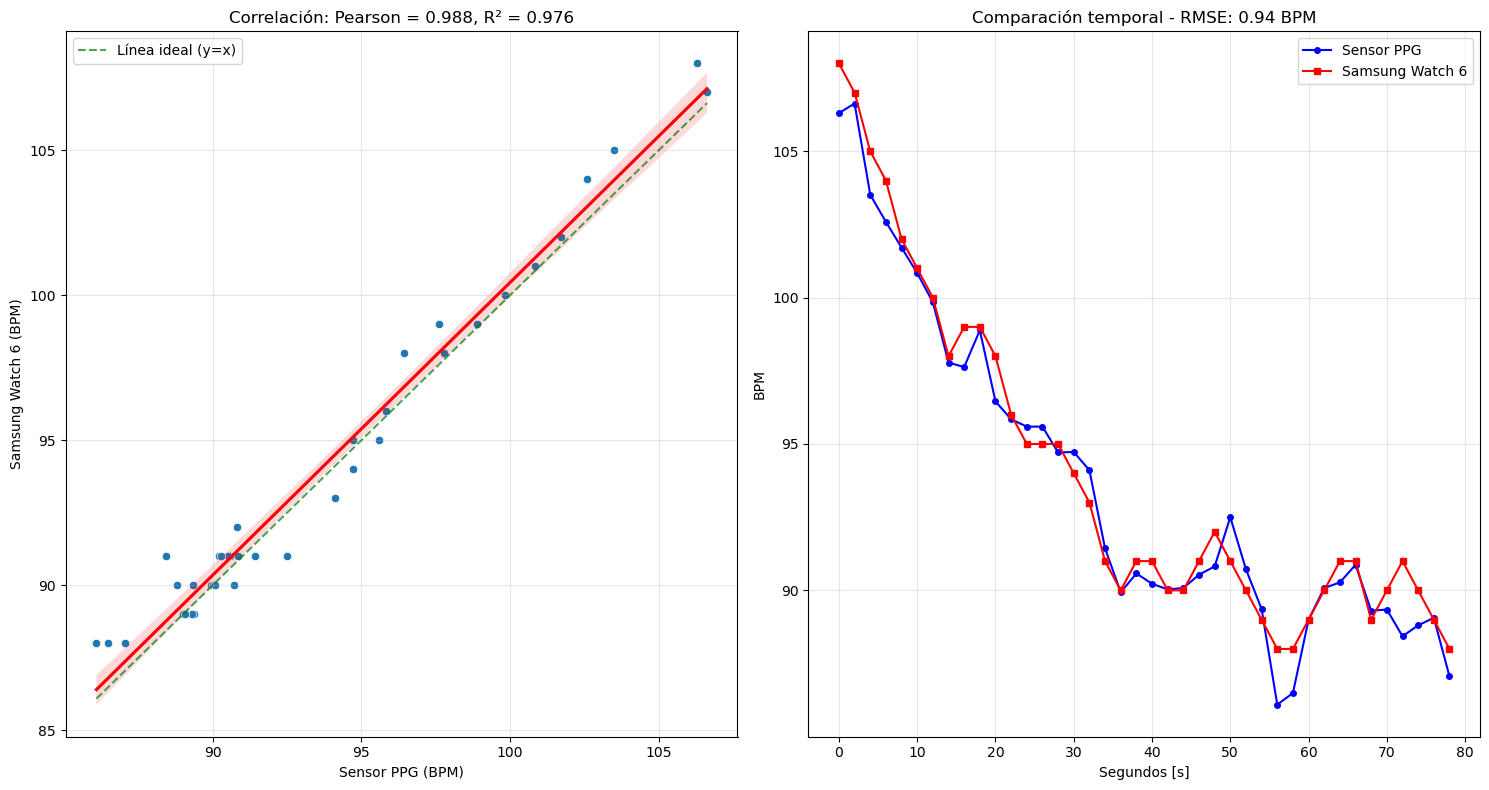

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# 1. Diagrama de dispersión con línea de regresión
sns.scatterplot(x=sensor_bpm, y=watch_bpm, ax=ax1)
sns.regplot(x=sensor_bpm, y=watch_bpm, ax=ax1, scatter=False, color='red')
ax1.plot([sensor_bpm.min(), sensor_bpm.max()], [sensor_bpm.min(), sensor_bpm.max()], 
         'g--', alpha=0.7, label='Línea ideal (y=x)')
ax1.set_xlabel('Sensor PPG (BPM)')
ax1.set_ylabel('Samsung Watch 6 (BPM)')
ax1.set_title(f'Correlación: Pearson = {pearson_r:.3f}, R² = {r_squared:.3f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Series temporales
time_points = np.array(range(len(sensor_bpm))) * 2 # Asumiendo que cada punto es cada 2 segundos
ax2.plot(time_points, sensor_bpm, 'b-o', label='Sensor PPG', markersize=4)
ax2.plot(time_points, watch_bpm, 'r-s', label='Samsung Watch 6', markersize=4)
ax2.set_xlabel('Segundos [s]')
ax2.set_ylabel('BPM')
ax2.set_title(f'Comparación temporal - RMSE: {rmse:.2f} BPM')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== ANÁLISIS DE CORRELACIÓN ===
Correlación de Pearson: r = 0.9878 (p = 0.0000)
Coeficiente de determinación (R²): 0.9757

=== MÉTRICAS DE ERROR ===
Error Cuadrático Medio (RMSE): 0.94 BPM


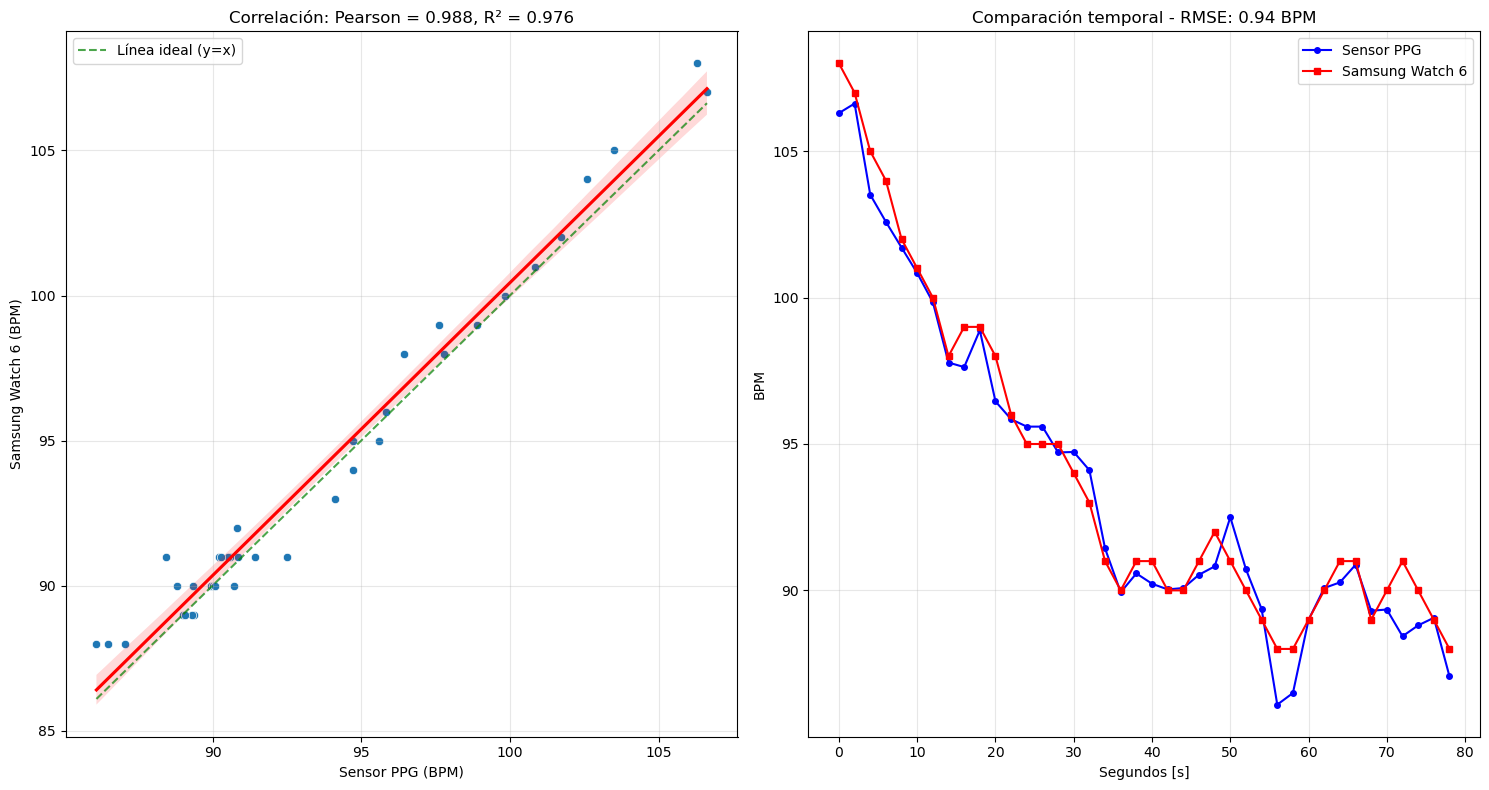

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Datos para análisis
csv_file = r"C:\Users\Eloy\Documents\PythonProjects\EMDR-Project\src\pipeline\combined_heart_rate_data.csv"
combined_df = pd.read_csv(csv_file)


sensor_bpm = combined_df['sensor_ppg_bpm'].values
watch_bpm = combined_df['samsung_watch_bpm'].values

print("=== ANÁLISIS DE CORRELACIÓN ===")

# 1. Correlación de Pearson (linealidad)
pearson_r, pearson_p = pearsonr(sensor_bpm, watch_bpm)
print(f"Correlación de Pearson: r = {pearson_r:.4f} (p = {pearson_p:.4f})")

# 3. Coeficiente de determinación
r_squared = pearson_r ** 2
print(f"Coeficiente de determinación (R²): {r_squared:.4f}")

print("\n=== MÉTRICAS DE ERROR ===")

# 5. Error Cuadrático Medio (RMSE)
rmse = np.sqrt(mean_squared_error(watch_bpm, sensor_bpm))
print(f"Error Cuadrático Medio (RMSE): {rmse:.2f} BPM")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# 1. Diagrama de dispersión con línea de regresión
sns.scatterplot(x=sensor_bpm, y=watch_bpm, ax=ax1)
sns.regplot(x=sensor_bpm, y=watch_bpm, ax=ax1, scatter=False, color='red')
ax1.plot([sensor_bpm.min(), sensor_bpm.max()], [sensor_bpm.min(), sensor_bpm.max()], 
         'g--', alpha=0.7, label='Línea ideal (y=x)')
ax1.set_xlabel('Sensor PPG (BPM)')
ax1.set_ylabel('Samsung Watch 6 (BPM)')
ax1.set_title(f'Correlación: Pearson = {pearson_r:.3f}, R² = {r_squared:.3f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Series temporales
time_points = np.array(range(len(sensor_bpm))) * 2 # Asumiendo que cada punto es cada 2 segundos
ax2.plot(time_points, sensor_bpm, 'b-o', label='Sensor PPG', markersize=4)
ax2.plot(time_points, watch_bpm, 'r-s', label='Samsung Watch 6', markersize=4)
ax2.set_xlabel('Segundos [s]')
ax2.set_ylabel('BPM')
ax2.set_title(f'Comparación temporal - RMSE: {rmse:.2f} BPM')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()